In [ ]:
!pip install arch

In [ ]:
import json, time, os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from requests import Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
ARCH_AVAILABLE = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 47.2 MB/s eta 0:00:00
Enter your CoinMarketCap API key: a76bd6fc-2b66-4a25-843f-321def3437bd
Loaded 10 coins.
Fetching historical data (or loading cached files)...
[INFO] Using cached data for 1
[INFO] Using cached data for 1027
[INFO] Using cached data for 1839
[INFO] Using cached data for 3408
[INFO] Using cached data for 5426
[INFO] Using cached data for 1831
[INFO] Using cached data for 3957
[INFO] Using cached data for 1975
[INFO] Using cached data for 328
[INFO] Using cached data for 1437

✅ Fetched or loaded data for 10 coins.


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004616. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


Train Samples: 470
Val Samples:   157
Test Samples:  157
Epoch [1/200] | Train Loss: 0.697061 | Train Acc: 49.36% | Val Loss: 0.695147 | Val Acc: 47.13%
Epoch [2/200] | Train Loss: 0.693792 | Train Acc: 49.36% | Val Loss: 0.691197 | Val Acc: 52.87%
Epoch [3/200] | Train Loss: 0.693060 | Train Acc: 51.06% | Val Loss: 0.689806 | Val Acc: 52.87%
Epoch [4/200] | Train Loss: 0.693078 | Train Acc: 50.43% | Val Loss: 0.690948 | Val Acc: 54.78%
Epoch [5/200] | Train Loss: 0.691960 | Train Acc: 51.91% | Val Loss: 0.691271 | Val Acc: 57.32%
Epoch [6/200] | Train Loss: 0.690981 | Train Acc: 52.55% | Val Loss: 0.689317 | Val Acc: 56.69%
Epoch [7/200] | Train Loss: 0.686754 | Train Acc: 54.47% | Val Loss: 0.691050 | Val Acc: 57.96%
Epoch [8/200] | Train Loss: 0.692572 | Train Acc: 52.13% | Val Loss: 0.692445 | Val Acc: 44.59%
Epoch [9/200] | Train Loss: 0.686067 | Train Acc: 55.32% | Val Loss: 0.697844 | Val Acc: 48.41%
Epoch [10/200] | Train Loss: 0.689866 | Train Acc: 52.34% | Val Loss: 0.696548 

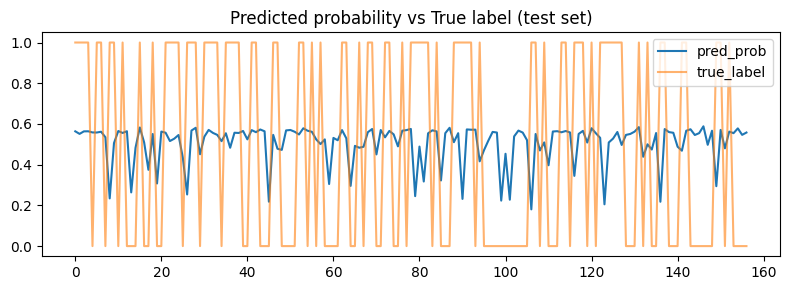

[DONE] Script finished.


In [ ]:
# ----------------------------
# 1. CoinMarketCap API Helper
# ----------------------------
class CryptoEndpoint:
    listingsEndpoint = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
    latestQuotes = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/latest"
    historicalQuotes = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/historical"

    def __init__(self, apikey) -> None:
        self.headers = {
            'Accepts': 'application/json',
            'X-CMC_PRO_API_KEY': apikey,
        }
        self.coinsInfo = {}
        self.coinsIds = []

    def GetCoinIdentifiers(self, limit=10):
        session = Session()
        session.headers.update(self.headers)
        response = session.get(
            url=self.listingsEndpoint,
            params={"limit": limit, "price_min": 1, "price_max": 100000}
        )

        if response.status_code != 200:
            raise Exception(f"Error fetching listings: {response.text}")

        data = json.loads(response.text)

        for coin in data.get("data", []):
            self.coinsInfo[coin["name"]] = coin["id"]
            self.coinsIds.append(coin["id"])

        print(f"Loaded {len(self.coinsInfo)} coins.")
        return (self.coinsInfo, self.coinsIds)

    def GetSampleCoinHistoricalData(self, coin_id, days=60):
        """Fetch historical daily prices for one coin. Returns list of rows [price, volume, marketcap, circulating_supply, total_supply]."""
        session = Session()
        session.headers.update(self.headers)

        end_time = datetime.utcnow()
        start_time = end_time - timedelta(days=days)

        params = {
            "id": coin_id,
            "time_start": start_time.isoformat(),
            "time_end": end_time.isoformat(),
            "interval": "24h",
        }

        response = session.get(url=self.historicalQuotes, params=params)
        if response.status_code != 200:
            print(f"Error for coin {coin_id}: {response.text}")
            return []

        data = json.loads(response.text)
        if data.get("status", {}).get("error_code") != 0:
            print(f"API error for {coin_id}: {data['status']}")
            return []

        coin_data = data.get("data", {})
        quotes = coin_data.get("quotes", [])
        if not quotes:
            return []

        historicals = []
        for quote in quotes:
            q = quote.get("quote", {}).get("USD", {})
            price = q.get("price", np.nan)
            volume = q.get("volume_24h", np.nan)
            marketcap = q.get("market_cap", np.nan)
            circulating_supply = q.get("circulating_supply", np.nan)
            total_supply = q.get("total_supply", np.nan)
            historicals.append([price, volume, marketcap, circulating_supply, total_supply])

        return historicals

# ----------------------------
# 2. GARCH helper (optional arch)
# ----------------------------

def compute_log_returns(price_arr):
    price_arr = np.asarray(price_arr, dtype=float)
    # avoid division by zero
    eps = 1e-12
    return np.log(price_arr[1:] / (price_arr[:-1] + eps) + 1e-12)

def add_garch_volatility(all_data, days_for_garch=60, vol_col_name="garch_vol"):
    """
    For each coin DataFrame in all_data (assumed columns: price, volume, marketcap, circ_supply, total_supply)
    compute a volatility series (same length as rows) and append as an extra column to each df.
    Returns a new dict with dataframe objects that include the volatility feature.
    """
    new_data = {}
    for coin_id, df in all_data.items():
        df = df.copy()
        if df.shape[1] < 1:
            df[vol_col_name] = 0.0
            new_data[coin_id] = df
            continue

        prices = np.asarray(df.iloc[:, 0], dtype=float)
        n = len(prices)
        vol = np.zeros(n)

        if n < 3:
            df[vol_col_name] = vol + 1e-6
            new_data[coin_id] = df
            continue

        returns = compute_log_returns(prices)  # len n-1

        try:
            if ARCH_AVAILABLE and len(returns) >= 20:
                # Fit GARCH(1,1) to returns (scaled)
                am = arch_model(returns * 100.0, vol='Garch', p=1, q=1, dist='normal')
                res = am.fit(disp='off')
                cond_vol = res.conditional_volatility / 100.0
                # align: vol[1:] corresponds to cond_vol (since returns index i => price[i+1])
                vol[1:] = cond_vol
            else:
                # fallback: rolling std on returns
                window = min(10, max(2, len(returns)//4))
                roll = pd.Series(returns).rolling(window=window, min_periods=1).std().fillna(method='bfill').values
                vol[1:] = roll
        except Exception as e:
            # robust fallback
            window = min(10, max(2, len(returns)//4))
            roll = pd.Series(returns).rolling(window=window, min_periods=1).std().fillna(method='bfill').values
            vol[1:] = roll

        vol = np.nan_to_num(vol, nan=1e-6)
        vol[vol <= 0] = 1e-6
        df[vol_col_name] = vol
        new_data[coin_id] = df

    return new_data

# ----------------------------
# 3. Data Preparation Utility (with vol)
# ----------------------------
def prepare_sequences_with_vol(data_dict, window=10, vol_col_name="garch_vol"):
    """
    Convert dict {coin_id: DataFrame} into windowed tensors.
    Expects first col = price, and a column named vol_col_name for volatility.
    Target: 1 if next price > current price, else 0
    """
    scaler = MinMaxScaler()
    X, Y, labels = [], [], []

    for coin_id, df in data_dict.items():
        # Ensure vol_col exists
        if vol_col_name not in df.columns:
            # compute fallback vol
            prices = np.asarray(df.iloc[:, 0], dtype=float)
            if len(prices) >= 2:
                returns = compute_log_returns(prices)
                roll = np.concatenate([[0.0], pd.Series(returns).rolling(5, min_periods=1).std().fillna(method='bfill').values])
            else:
                roll = np.zeros(len(prices))
            df[vol_col_name] = roll

        # pick columns: price, volume, marketcap, circ_supply, total_supply, vol
        # if df has fewer columns, fill missing with zeros
        required_cols = []
        cols = list(df.columns)
        # try to keep original ordering: first 5 numeric columns, then vol
        base_cols = cols[:5] if len(cols) >= 5 else cols[:len(cols)]
        # ensure we include vol_col_name at end
        selected_cols = base_cols.copy()
        if vol_col_name not in selected_cols:
            selected_cols.append(vol_col_name)

        arr = df[selected_cols].values.astype(float)

        if len(arr) <= window + 1:
            continue

        # scale features per-coin
        scaled = scaler.fit_transform(arr)
        prices = arr[:, 0]

        for i in range(len(scaled) - window - 1):
            X.append(scaled[i:i+window])
            next_dir = 1.0 if prices[i+window+1] > prices[i+window] else 0.0
            Y.append(next_dir)
            labels.append(coin_id)

    if len(X) == 0:
        return torch.empty((0,)), torch.empty((0,)), []

    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32).view(-1, 1)
    return X, Y, labels

# ----------------------------
# 4. Model & Training
# ----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, output_dim)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]  # last time-step
        logits = self.fc(out)
        return logits, None

def train_model(model, trainX, trainY, valX, valY, epochs=200, lr=0.01, patience=50):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.2)

    # Ensure tensors are on correct device
    trainX = trainX.to(device)
    trainY = trainY.to(device)
    valX   = valX.to(device)
    valY   = valY.to(device)

    noImprovment = 0
    best_comb_acc = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        outputs, _ = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs, _ = model(valX)
            val_loss = criterion(val_outputs, valY)

            pred_train = torch.sigmoid(outputs)
            train_acc = (pred_train.round() == trainY).float().mean().item()

            pred_val = torch.sigmoid(val_outputs)
            val_acc = (pred_val.round() == valY).float().mean().item()

        # Step scheduler using validation loss
        scheduler.step(val_loss)
        if (train_acc + val_acc) / 2 > best_comb_acc:
            noImprovment = 0
            best_comb_acc = (train_acc + val_acc) / 2
        else:
            noImprovment += 1

        if noImprovment > patience:
            print(f"[INFO] Early stopping at epoch {epoch+1}")
            return model

        if (epoch + 1) % 1 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] | "
                f"Train Loss: {loss.item():.6f} | Train Acc: {train_acc*100:.2f}% | "
                f"Val Loss: {val_loss.item():.6f} | Val Acc: {val_acc*100:.2f}%"
            )

    return model

# ----------------------------
# 5. Get and Save Data as CSV
# ----------------------------
def GetSaveData():
    apikey = input("Enter your CoinMarketCap API key: ").strip()
    ce = CryptoEndpoint(apikey)

    data_dir = "data"
    os.makedirs(data_dir, exist_ok=True)

    freshness_days = 1  # re-download if older than this many days

    coinsInfo, coinsIds = ce.GetCoinIdentifiers(limit=10)
    print("Fetching historical data (or loading cached files)...")

    all_data = {}

    for coinId in coinsIds:
        file_path = os.path.join(data_dir, f"{coinId}.csv")

        if os.path.exists(file_path):
            modified_time = datetime.fromtimestamp(os.path.getmtime(file_path))
            if datetime.now() - modified_time < timedelta(days=freshness_days):
                print(f"[INFO] Using cached data for {coinId}")
                df = pd.read_csv(file_path)
                all_data[coinId] = df
                continue
            else:
                print(f"[INFO] Cached data for {coinId} is old. Refetching...")

        hist = ce.GetSampleCoinHistoricalData(coinId, days=90)
        if len(hist) > 0:
            df = pd.DataFrame(hist, columns=["price", "volume", "marketcap", "circulating_supply", "total_supply"])
            df.to_csv(file_path, index=False)
            print(f"[INFO] Saved new data for {coinId} → {file_path}")
            all_data[coinId] = df
        else:
            print(f"[WARN] No data found for {coinId}")

        time.sleep(1)  # avoid tight rate limits

    print(f"\n✅ Fetched or loaded data for {len(all_data)} coins.")
    return all_data

# ----------------------------
# 6. Residual GARCH helper
# ----------------------------
def fit_garch_on_residuals(y_true_returns, y_pred_returns):
    """
    Fit a GARCH(1,1) on residuals (true_return - pred_return).
    Returns fitted model object if arch available, else None.
    """
    if len(y_true_returns) == 0:
        return None
    resid = (y_true_returns - y_pred_returns)
    if ARCH_AVAILABLE and len(resid) >= 20:
        try:
            am = arch_model(resid * 100.0, vol='Garch', p=1, q=1, dist='normal')
            res = am.fit(disp='off')
            return res
        except Exception:
            return None
    return None

# ----------------------------
# 7. Main Execution (end-to-end)
# ----------------------------
if __name__ == "__main__":
    # 1) Fetch data (or load cached CSVs)
    all_data = GetSaveData()

    # 2) Compute per-coin volatility and append as a feature
    all_data_with_vol = add_garch_volatility(all_data, days_for_garch=90, vol_col_name="garch_vol")

    # 3) Prepare sequences
    WINDOW = 10
    X_all, Y_all, labels = prepare_sequences_with_vol(all_data_with_vol, window=WINDOW, vol_col_name="garch_vol")

    if X_all.numel() == 0:
        print("No sequences available (not enough data). Exiting.")
        raise SystemExit

    # 4) Train/Val/Test split (60/20/20)
    trainX, restX, trainY, restY = train_test_split(
        X_all, Y_all, test_size=0.4, shuffle=True, random_state=42
    )
    valX, testX, valY, testY = train_test_split(
        restX, restY, test_size=0.5, shuffle=True, random_state=42
    )

    # Move to device
    trainX_t = trainX.to(device)
    trainY_t = trainY.to(device)
    valX_t   = valX.to(device)
    valY_t   = valY.to(device)
    testX_t  = testX.to(device)
    testY_t  = testY.to(device)

    print(f"Train Samples: {len(trainX)}")
    print(f"Val Samples:   {len(valX)}")
    print(f"Test Samples:  {len(testX)}")

    # 5) Build model (input_dim determined from X shape)
    input_dim = X_all.shape[2]  # should be 6 (5 original + vol) in most cases
    model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=2, output_dim=1).to(device)

    # 6) Train
    trained_model = train_model(model, trainX_t, trainY_t, valX_t, valY_t, epochs=200, lr=0.01, patience=25)

    # 7) Evaluate on test set
    trained_model.eval()
    with torch.no_grad():
        logits, _ = trained_model(testX_t)
        preds = torch.sigmoid(logits)
        pred_classes = preds.round()

        test_loss = nn.BCEWithLogitsLoss()(logits, testY_t).item()
        test_acc = (pred_classes == testY_t).float().mean().item()

    print("\n===== TEST RESULTS (Hybrid LSTM-GARCH) =====")
    print(f"Test Loss: {test_loss:.6f}")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print("============================================\n")

    # 8) OPTIONAL: Fit GARCH on LSTM residuals (requires alignment to true returns)
    # Build the true returns sequence aligned with X_all in the same order the prepare function used.
    true_returns = []
    for coin_id, df in all_data_with_vol.items():
        cols = list(df.columns)
        base_cols = cols[:5] if len(cols) >= 5 else cols[:len(cols)]
        selected_cols = base_cols.copy()
        if "garch_vol" not in selected_cols:
            selected_cols.append("garch_vol")
        arr = df[selected_cols].values.astype(float)
        prices = arr[:, 0]
        if len(prices) <= WINDOW + 1:
            continue
        for i in range(len(prices) - WINDOW - 1):
            r = np.log(prices[i + WINDOW + 1] / (prices[i + WINDOW] + 1e-12))
            true_returns.append(r)
    true_returns = np.array(true_returns)

    # Model predictions on all sequences
    with torch.no_grad():
        all_logits, _ = model(X_all.to(device))
        all_probs = torch.sigmoid(all_logits).cpu().numpy().flatten()

    # Heuristic: map probabilities to small returns scale (approx). This is a heuristic since model is classifier.
    rstd = np.std(true_returns) if len(true_returns) > 0 else 1e-6
    pred_returns = (all_probs - 0.5) * 2.0 * rstd  # in [-rstd, +rstd]

    if len(true_returns) == len(pred_returns):
        garch_on_res = fit_garch_on_residuals(true_returns, pred_returns)
        if garch_on_res is not None:
            print("[INFO] Fitted GARCH on LSTM residuals.")
        else:
            print("[INFO] Could not fit GARCH on residuals (insufficient data or arch missing).")
    else:
        print("[WARN] true_returns and model predictions lengths mismatch; skipping residual GARCH fit.")

    # 9) Example of volatility-adjusted thresholding
    def volatility_adjusted_threshold(prob, vol, k=1.5, base=0.5):
        return base + k * vol

    # Example: take first test sample and show its vol and threshold
    sample_idx = 0
    sample_vol = testX.cpu().numpy()[sample_idx, -1, -1]  # last time-step vol feature
    sample_prob = pred_classes.cpu().numpy().flatten()[0] if pred_classes.numel() > 0 else None
    sample_threshold = volatility_adjusted_threshold(0.5, sample_vol)
    print(f"[INFO] Example sample vol={sample_vol:.6f}, volatility-adjusted threshold={sample_threshold:.4f}")

    # (Optional) Plot test predictions vs true labels (small convenience)
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,3))
        plt.plot(preds.cpu().numpy(), label="pred_prob")
        plt.plot(testY_t.cpu().numpy(), label="true_label", alpha=0.6)
        plt.title("Predicted probability vs True label (test set)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    print("[DONE] Script finished.")
